In [1]:
# !pip install -q supervision "ultralytics<=8.3.40"

In [2]:
import cv2
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

# from process_video import process_video

import torch
from torch.nn.utils.rnn import pad_sequence
from torch import nn
import pytorch_lightning as pl
import torchmetrics
from torchmetrics import Metric
from torch.utils.data import DataLoader, Dataset, random_split
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar
torch.manual_seed(47)

### Process Video

In [3]:
from view_transformer import ViewTransformer

# CONFIGURATION
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_RESOLUTION = 1280


def process_video(source: np.array, target: np.array, source_video_path: str, target_video_path: str, model_name: str, output_csv: str) -> None:
    # TRANSFORM PERSPECTIVE
    view_transformer = ViewTransformer(source=source, target=target)

    model = YOLO(model_name)

    video_info = sv.VideoInfo.from_video_path(video_path=source_video_path)
    frame_generator = sv.get_video_frames_generator(source_path=source_video_path)

    # tracker initiation
    byte_track = sv.ByteTrack(frame_rate=video_info.fps)

    # annotators configuration
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=video_info.resolution_wh)
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=video_info.resolution_wh)
    bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_scale=text_scale,
        text_thickness=thickness,
        text_position=sv.Position.BOTTOM_CENTER
    )
    trace_annotator = sv.TraceAnnotator(
        thickness=thickness,
        trace_length=video_info.fps * 2,
        position=sv.Position.BOTTOM_CENTER
    )
    polygon_zone = sv.PolygonZone(polygon=source)
    coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

    frame_count = 0
    output_data = []

    # open target video
    with sv.VideoSink(target_video_path, video_info) as sink:

        # loop over source video frame
        for frame in tqdm(frame_generator, total=video_info.total_frames):
            frame_count += 1
            result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
            detections = sv.Detections.from_ultralytics(result)

            # filter out detections by class and confidence
            detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
            detections = detections[detections.class_id == 2]

            # filter out detections outside the zone
            detections = detections[polygon_zone.trigger(detections)]

            # refine detections using non-max suppression
            detections = detections.with_nms(IOU_THRESHOLD)

            # pass detection through the tracker
            detections = byte_track.update_with_detections(detections=detections)

            points = detections.get_anchors_coordinates(
                anchor=sv.Position.BOTTOM_CENTER
            )

            # calculate the detections position inside the target RoI
            points = view_transformer.transform_points(points=points).astype(int)

            # store detections position
            for tracker_id, [_, y] in zip(detections.tracker_id, points):
                coordinates[tracker_id].append(y)

            # format labels
            labels = []

            for tracker_id in detections.tracker_id:
                if len(coordinates[tracker_id]) < video_info.fps / 2:
                    labels.append(f"#{tracker_id}")
                    speed = -1
                else:
                    # calculate speed
                    coordinate_start = coordinates[tracker_id][-1]
                    coordinate_end = coordinates[tracker_id][0]
                    distance = abs(coordinate_start - coordinate_end)
                    time = len(coordinates[tracker_id]) / video_info.fps
                    speed = distance / time * 3.6
                    labels.append(f"#{tracker_id} {int(speed)} km/h")
                output_data.append([tracker_id, frame_count, *detections[detections.tracker_id == tracker_id].xyxy[0].tolist(), speed])

            # annotate frame
            annotated_frame = frame.copy()
            annotated_frame = trace_annotator.annotate(
                scene=annotated_frame, detections=detections
            )
            annotated_frame = bounding_box_annotator.annotate(
                scene=annotated_frame, detections=detections
            )
            annotated_frame = label_annotator.annotate(
                scene=annotated_frame, detections=detections, labels=labels
            )

            # add frame to target video
            sink.write_frame(annotated_frame)

    df = pd.DataFrame(data=output_data, columns=["track_id", "frames", "x1", "y1", "x2", "y2", "speed"])
    df = df[df["speed"] != -1]  # Eliminar registros sin velocidad estimada
    # Calcular las coordenadas del centro a partir de x1, y1, x2, y2
    df["center_x"] = (df["x1"] + df["x2"]) / 2.0
    df["center_y"] = (df["y1"] + df["y2"]) / 2.0
    df["speed_smoth"] = (
        df.groupby("track_id")["speed"]
        .transform(lambda x: x.rolling(window=7, center=True)
                            .mean()
                            .fillna(method="bfill")
                            .fillna(method="ffill"))
    )
    df.to_csv(output_csv, index=False)
    print("Output saved to ", output_csv)
    return df

In [4]:
SOURCE_VIDEO_PATH = "../media/vehicles.mp4"
TARGET_VIDEO_PATH = "../media/vehicles-result.mp4"
MODEL_NAME = "../models/yolov8x.pt"
OUTPUT_CSV = "data/output.csv"
TARGET_WIDTH = 25
TARGET_HEIGHT = 250
SOURCE = np.array([[1252, 787], [2298, 803], [5039, 2159], [-550, 2159]])
TARGET = np.array([[0, 0], [TARGET_WIDTH - 1, 0], [TARGET_WIDTH - 1, TARGET_HEIGHT - 1], [0, TARGET_HEIGHT - 1],])

# df = process_video(
#     source=SOURCE,
#     target=TARGET,
#     source_video_path=SOURCE_VIDEO_PATH,
#     target_video_path=TARGET_VIDEO_PATH,
#     model_name=MODEL_NAME,
#     output_csv=OUTPUT_CSV,
# )

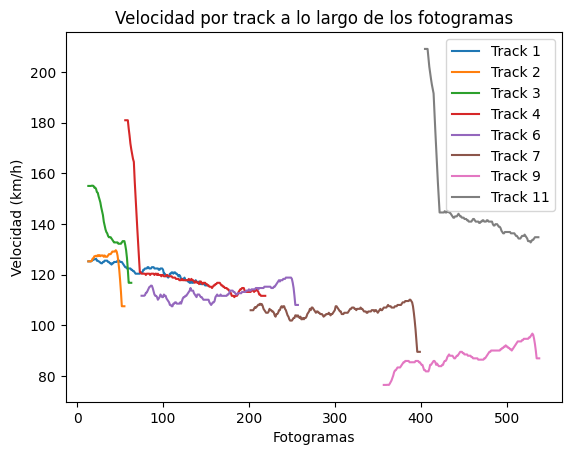

In [5]:
df = pd.read_csv(OUTPUT_CSV)
for i, (track_id, group) in enumerate(df.groupby("track_id")):
    if i > 10:
        break
    plt.plot(group["frames"], group["speed_smoth"], label=f"Track {track_id}")

plt.legend()
plt.xlabel("Fotogramas")
plt.ylabel("Velocidad (km/h)")
plt.title("Velocidad por track a lo largo de los fotogramas")
plt.show()

In [6]:
# --- 2. Dataset
class TrackingDataset(Dataset):
    def __init__(self, csv_path, seq_length=10):
        df = pd.read_csv(csv_path)
        
        # Agrupar por track_id para extraer la secuencia de cada vehículo
        self.track_groups = df.groupby("track_id")
        self.seq_length = seq_length
        self.samples, self.labels = [], []
        for track_id, group in self.track_groups:
            # Ordenar por frame
            group = group.sort_values("frames")
            
            # Usamos los centros como entrada
            centers = group[["x1", "y1", "x2", "y2"]].values
            speeds = group["speed"].values
            
            # Crear ventanas deslizantes para cada vehículo
            if len(centers) > seq_length:
                for i in range(len(centers) - seq_length):
                    self.samples.append(centers[i:i+seq_length])
                    self.labels.append(speeds[i+seq_length])
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        # Cada entrada es una secuencia [seq_length x 2] y la etiqueta es un escalar (velocidad)
        return (torch.tensor(self.samples[idx], dtype=torch.float32),
                torch.tensor(self.labels[idx], dtype=torch.float32))


In [7]:
dataset = TrackingDataset(OUTPUT_CSV, seq_length=20)
for seq_len in [10, 20, 30]:
    dataset = TrackingDataset(OUTPUT_CSV, seq_length=seq_len)
    print(f"Tamaño del dataset con seq_length={seq_len}: {len(dataset)}")

Tamaño del dataset con seq_length=10: 1014
Tamaño del dataset con seq_length=20: 934
Tamaño del dataset con seq_length=30: 854


In [8]:
# --- 3. DataModule para PyTorch Lightning ---
class TrackingDataModule(pl.LightningDataModule):
    def __init__(self, csv_path, seq_length=10, batch_size=16, split_ratio=(0.7, 0.15, 0.15), num_workers=4):
        super().__init__()
        self.csv_path = csv_path
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.split_ratio = split_ratio
        self.num_workers = num_workers

    def setup(self, stage=None):
        # Crear el dataset completo
        dataset = TrackingDataset(self.csv_path, seq_length=self.seq_length)
        total = len(dataset)
        train_size = int(total * self.split_ratio[0])
        val_size = int(total * self.split_ratio[1])
        test_size = total - train_size - val_size
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(dataset, [train_size, val_size, test_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

In [9]:
# Métrica personalizada para regresión: Porcentaje de predicciones con error absoluto menor a un umbral.
class CustomRegressionAccuracy(Metric):
    def __init__(self, threshold: float = 5.0, dist_sync_on_step: bool = False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.threshold = threshold
        self.add_state("correct", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0.0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        # Asegurarse que ambos sean vectores 1D
        preds = preds.view(-1)
        target = target.view(-1)
        diff = torch.abs(preds - target)
        self.correct += torch.sum((diff < self.threshold).float())
        self.total += torch.tensor(target.numel(), dtype=torch.float)

    def compute(self):
        return self.correct / self.total


class TrackingLSTM(pl.LightningModule):
    def __init__(self, input_size=2, hidden_size=50, num_layers=2, output_size=1, lr=0.0001, threshold=5.0, dropout=0.3):
        """
        threshold: margen de error en km/h para considerar una predicción como correcta.
        """
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.loss_fn = nn.MSELoss()
        self.lr = lr
        self.threshold = threshold

        # Métricas para el conjunto de entrenamiento
        self.train_mse = torchmetrics.MeanSquaredError()
        self.train_mae = torchmetrics.MeanAbsoluteError()
        self.train_reg_acc = CustomRegressionAccuracy(threshold=threshold)
        
        # Métricas para el conjunto de validación
        self.val_mse = torchmetrics.MeanSquaredError()
        self.val_mae = torchmetrics.MeanAbsoluteError()
        self.val_reg_acc = CustomRegressionAccuracy(threshold=threshold)
        
        # Métricas para el conjunto de test
        self.test_mse = torchmetrics.MeanSquaredError()
        self.test_mae = torchmetrics.MeanAbsoluteError()
        self.test_reg_acc = CustomRegressionAccuracy(threshold=threshold)


    def forward(self, x):
        # x shape: [batch, seq_length, input_size]
        lstm_out, _ = self.lstm(x)
        # Se toma la salida del último timestep
        out = self.dropout(lstm_out[:, -1, :])
        return self.fc(out)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat.squeeze(), y)     
        self.log("train_loss", loss, prog_bar=True)

        self.train_mse(y_hat, y)
        self.train_mae(y_hat, y)
        self.train_reg_acc(y_hat, y)

        self.log("train_mse", self.train_mse, on_step=False, on_epoch=True, prog_bar=False)
        self.log("train_mae", self.train_mae, on_step=False, on_epoch=True, prog_bar=False)
        self.log("train_reg_acc", self.train_reg_acc, on_step=False, on_epoch=True, prog_bar=False)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat.squeeze(), y)
        self.log("val_loss", loss, prog_bar=True)

        self.val_mse(y_hat, y)
        self.val_mae(y_hat, y)
        self.val_reg_acc(y_hat, y)

        self.log("val_mse", self.val_mse, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val_mae", self.val_mae, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val_reg_acc", self.val_reg_acc, on_step=False, on_epoch=True, prog_bar=False)

        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat.squeeze(), y)
        self.log("test_loss", loss)

        self.test_mse(y_hat, y)
        self.test_mae(y_hat, y)
        self.test_reg_acc(y_hat, y)

        self.log("test_mse", self.test_mse, on_step=False, on_epoch=True)
        self.log("test_mae", self.test_mae, on_step=False, on_epoch=True)
        self.log("test_reg_acc", self.test_reg_acc, on_step=False, on_epoch=True)

        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [ ]:
seq_length = 20
batch_size = 4
split_ratio = (0.8, 0.1, 0.1)
n_epochs = 200
num_workers = 4

data_module = TrackingDataModule(
    csv_path=OUTPUT_CSV, 
    seq_length=seq_length, 
    batch_size=batch_size, 
    split_ratio=split_ratio,
    num_workers=num_workers
)

model = TrackingLSTM(
    input_size=4,
    hidden_size=128,
    num_layers=2,
    output_size=1,
    lr=0.0001,
    dropout=0.3
)

In [11]:
logger = CSVLogger("logs/", name="tracking_lstm")

callback_checkpoint = ModelCheckpoint(
    save_top_k=1,
    mode='min', 
    monitor='val_loss'
)
callback_tqdm = TQDMProgressBar(leave=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

trainer = pl.Trainer(
    max_epochs=n_epochs,
    callbacks=[callback_checkpoint, early_stopping_callback, callback_tqdm],
    accelerator="auto",
    devices="auto",
    logger=logger,
    deterministic=False,
    log_every_n_steps=10,
)
trainer.fit(model, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name          | Type                     | Params | Mode 
--------------------------------------------------------------------
0  | lstm          | LSTM                     | 200 K  | train
1  | dropout       | Dropout                  | 0      | train
2  | fc            | Linear          

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


: 

In [26]:
trainer.test(model, datamodule=data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     147.0282745361328     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 147.0282745361328}]

In [27]:
# --- 5. Predicciones con el modelo entrenado ---
def predict_sequence(model, sequence):
    """
    Recibe una secuencia (numpy array o lista) de tamaño [seq_length x 2] y retorna la velocidad predicha.
    """
    model.eval()
    with torch.no_grad():
        # Convertir la secuencia a tensor y agregar la dimensión batch
        sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)
        prediction = model(sequence_tensor)
    return prediction.item()

# Ejemplo: cargar una secuencia de la dataset de test para predecir
# Nota: se asume que data_module.test_dataset está definido
for i in range(10):
    sample_input, sample_label = data_module.test_dataset[i]
    predicted_speed = predict_sequence(model, sample_input.numpy())
    error = abs(predicted_speed - sample_label)
    print(f"Predicted speed: {predicted_speed:.2f} km/h, Real speed: {sample_label:.2f} km/h, Error: {error:.2f} km/h")

Predicted speed: 122.52 km/h, Real speed: 122.40 km/h, Error: 0.12 km/h
Predicted speed: 106.59 km/h, Real speed: 111.60 km/h, Error: 5.01 km/h
Predicted speed: 101.87 km/h, Real speed: 79.20 km/h, Error: 22.67 km/h
Predicted speed: 103.31 km/h, Real speed: 111.60 km/h, Error: 8.29 km/h
Predicted speed: 122.52 km/h, Real speed: 118.80 km/h, Error: 3.72 km/h
Predicted speed: 122.52 km/h, Real speed: 118.80 km/h, Error: 3.72 km/h
Predicted speed: 102.06 km/h, Real speed: 108.00 km/h, Error: 5.94 km/h
Predicted speed: 104.79 km/h, Real speed: 108.00 km/h, Error: 3.21 km/h
Predicted speed: 104.64 km/h, Real speed: 108.00 km/h, Error: 3.36 km/h
Predicted speed: 105.60 km/h, Real speed: 133.20 km/h, Error: 27.60 km/h


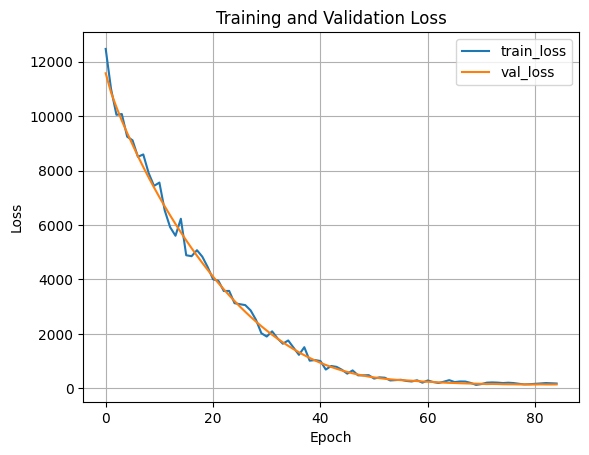

In [28]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, 
    legend=True, 
    xlabel="Epoch",
    ylabel="Loss", 
    # ylim=(0, 500),
    title="Training and Validation Loss", 
)
# df_metrics[["train_acc", "valid_acc"]].plot(
#     grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
# )

plt.show()